In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import libem
import numpy as np
from libvis import Visualizations
import matplotlib.pyplot as plt

from components import *

In [89]:
def generate_space(V_out=1, V_in=-1, grate_sp=0.2, th=0.05, ring_V=1, ring_r=0.1, ring_th=0.05, scale=20):
    sim = libem.EMSimulationSpace3D(space_size=(4, 2, 2), top_left=(-2, -1, -1), scale=scale)
    ring1_mask = EMObjectMasks.open_cylinder_in_plane(sim, (1, 0, 0), ring_r, ring_th, 0.9, 0, -1)
    sim.compute(make_enforcer(
        enf(EMObjects.planar_mesh_3d, (0, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_out),
        enf(EMObjects.planar_mesh_3d, (-0.5, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_in),
        enf(EMObjects.planar_mesh_3d, (-1, -0.8, -0.8), 0, (0.1, 1.6, 1.6), (grate_sp, grate_sp), th, V_out),
        enf(EMObjects.arbitrary_mask, ring1_mask, ring_V)
    ))
    sim.get_efield()
    return sim

In [90]:
OUTER_V = 1
INNER_V = 0
RING_V = 10
sim = generate_space(OUTER_V, INNER_V, 0.2, 0.02, RING_V, 0.5, 0.05, 20)
#sim.save("grid_sim_ON")
#sim = libem.EMSimulationSpace.load("grid_sim_OFF.npy")

Computed in 1023 iterations.


In [91]:
time_ranges = []
trajectories = []
blocked = []

end_time = 20
n_particles = 5

boundary = -1

xv_bias = -0.03
xv_radius = 0.03
yv_radius = 0.03
zv_radius = 0.03

print("Simulating particles:")
for i in range(n_particles):
    print("\r", i+1, end="")
    
    xv = max(xv_bias-xv_radius, min(xv_bias+xv_radius, np.random.normal(loc=xv_bias, scale=xv_radius)))
    yv = max(-yv_radius, min(yv_radius, np.random.normal(scale=yv_radius)))
    zv = max(-zv_radius, min(zv_radius, np.random.normal(scale=zv_radius)))
    
    p = libem.ChargedParticle3D(sim, 0.1, -1, (1.8, 0, 0), (xv, yv, zv), bounce=None)
    p.compute_motion((0, end_time))
    
    time_ranges.append(p.time)
    trajectories.append(p.position)
    blocked.append(p.position[0,-1] > boundary)
    
print("\rDone.")

print(len([b for b in blocked if not b]), "were not blocked.")

Simulating particles:
Done.
0 were not blocked.


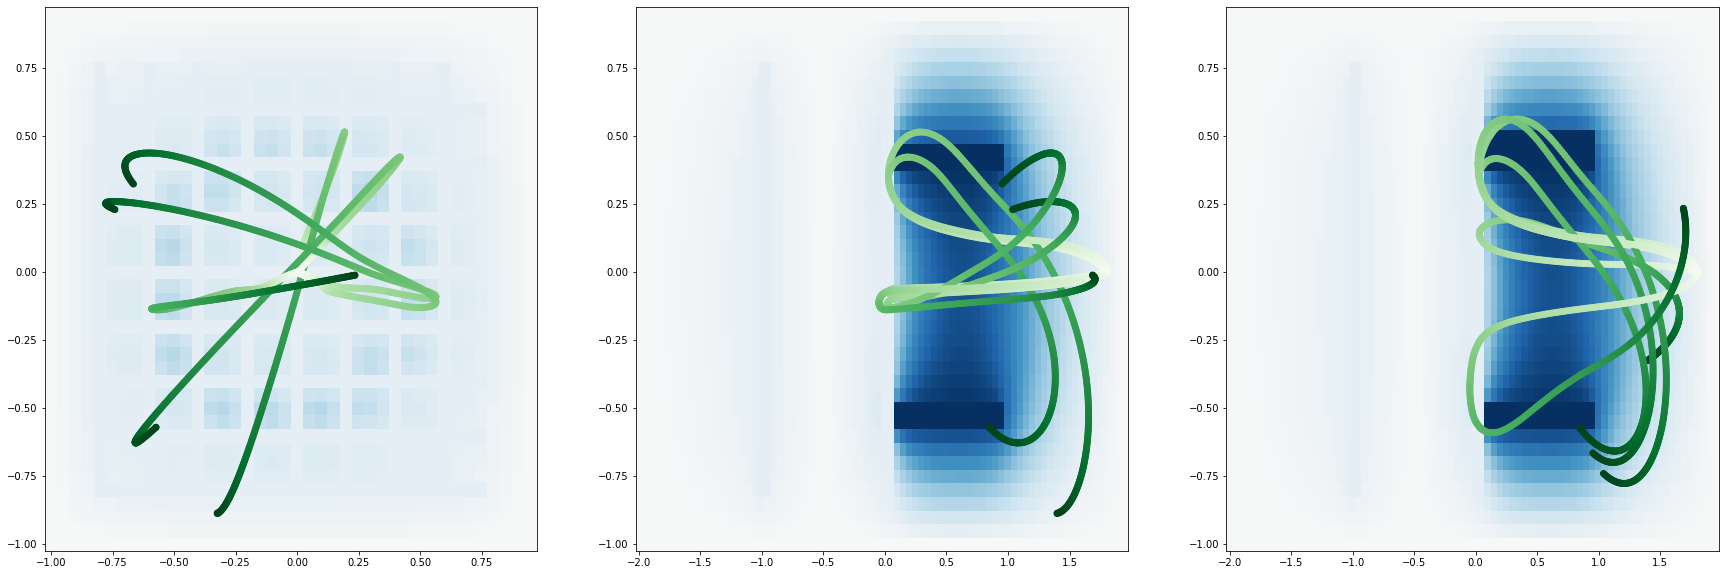

In [92]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axes):
    sim2d = libem.EMSimulationSpace2D.from_3d(sim, axis=i)
    Visualizations.colormesh_2d(sim2d, color_norm=max(abs(OUTER_V), abs(INNER_V), abs(RING_V), 1), graph_ax=ax)
    for p in range(len(trajectories)):
        Visualizations.trajectory_2d(time_ranges[p], trajectories[p], axis=i, graph_ax=ax)
